In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#dataset from https://www.kaggle.com/slothkong/10-monkey-species

In [28]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

train_dir='../input/10-monkey-species/training/training'
val_dir='../input/10-monkey-species/validation/validation'

cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
labels = pd.read_csv("../input/10-monkey-species/monkey_labels.txt", names=cols, skiprows=1)
labels

labels=labels['Common Name']
labels


0     mantled_howler                
1     patas_monkey                  
2     bald_uakari                   
3     japanese_macaque              
4     pygmy_marmoset                
5     white_headed_capuchin         
6     silvery_marmoset              
7     common_squirrel_monkey        
8     black_headed_night_monkey     
9     nilgiri_langur                
Name: Common Name, dtype: object

In [11]:
height = 256
width = 256
batch_sizes = 24
num_classes = 10
train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
                                                                       rotation_range=40,
                                                                       width_shift_range=0.2,
                                                                       height_shift_range=0.2,
                                                                       shear_range=0.2,
                                                                       zoom_range=0.2,
                                                                       horizontal_flip=True,
                                                                       fill_mode='nearest')

train_generator = train_data_generator.flow_from_directory(train_dir, target_size=(height, width),
                                                           batch_size = batch_sizes,
                                                           seed = 7,shuffle = True,
                                                           class_mode='categorical')

validation_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

validation_generator = validation_data_generator.flow_from_directory(val_dir,
                                                                     target_size=(height, width),
                                                                     batch_size=batch_sizes,shuffle = False,
                                                                     seed = 7, class_mode='categorical')

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [17]:
transfer_model = tf.keras.models.Sequential()
transfer_model.add(tf.keras.applications.ResNet50(include_top = False,
                                                  pooling = 'avg',
                                                  weights = 'imagenet'))
transfer_model.add(tf.keras.layers.Dense(1024,activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
transfer_model.add(tf.keras.layers.Dense(512,activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
transfer_model.add(tf.keras.layers.BatchNormalization())
transfer_model.add(tf.keras.layers.Dense(256,activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
transfer_model.add(tf.keras.layers.Dense(128,activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
transfer_model.add(tf.keras.layers.Dropout(rate=0.7))
transfer_model.add(tf.keras.layers.Dense(64,activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
transfer_model.add(tf.keras.layers.Dense(32,activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
transfer_model.add(tf.keras.layers.Dense(num_classes, activation = 'softmax'))
transfer_model.layers[0].trainable = False

transfer_model.compile(loss="categorical_crossentropy",
             optimizer="adam", metrics=['accuracy'])
transfer_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_22 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_23 (Dense)             (None, 512)               524800    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_24 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_25 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)              

In [30]:
epochs = 30
batch_size = 128
history = transfer_model.fit_generator(train_generator,
                                           steps_per_epoch = (train_generator.samples)//batch_size,
                                           epochs = epochs,
                                           validation_data = validation_generator,
                                           validation_steps=(validation_generator.samples)//batch_size )

Epoch 1/40
8/8 [==============================] - 28s 3s/step - loss: 0.2330 - accuracy: 0.9427 - val_loss: 0.1220 - val_accuracy: 0.9583
Epoch 2/40
8/8 [==============================] - 28s 3s/step - loss: 0.1964 - accuracy: 0.9323 - val_loss: 0.1080 - val_accuracy: 0.9583
Epoch 3/40
8/8 [==============================] - 27s 3s/step - loss: 0.2032 - accuracy: 0.9570 - val_loss: 0.0396 - val_accuracy: 0.9792
Epoch 4/40
8/8 [==============================] - 28s 4s/step - loss: 0.2048 - accuracy: 0.9271 - val_loss: 0.0226 - val_accuracy: 0.9792
Epoch 5/40
8/8 [==============================] - 27s 3s/step - loss: 0.1365 - accuracy: 0.9583 - val_loss: 0.0234 - val_accuracy: 1.0000
Epoch 6/40
8/8 [==============================] - 29s 4s/step - loss: 0.1879 - accuracy: 0.9479 - val_loss: 0.2878 - val_accuracy: 0.8958
Epoch 7/40
8/8 [==============================] - 27s 3s/step - loss: 0.1954 - accuracy: 0.9427 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 8/40
8/8 [==================

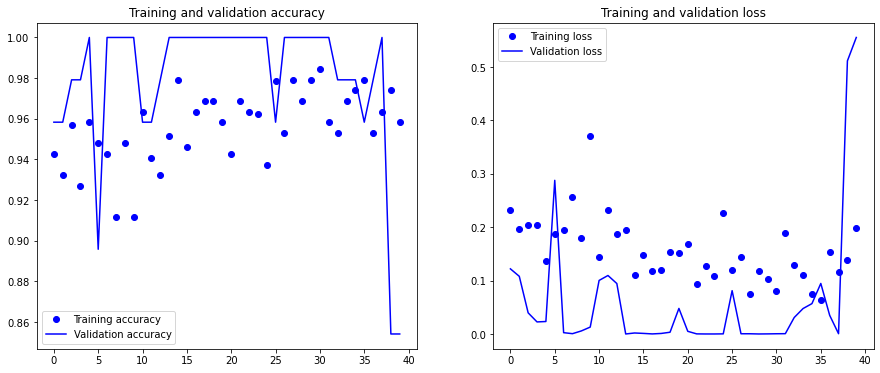

In [32]:

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.figure(figsize=(15,6))

plt.subplot(121)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
